In [ ]:
#|hide
#| eval: false
! pip install -Uqq wandb  # install wandb

In [ ]:
#|default_exp performance

# Model performance

> This notebook will compare performance of FFF with FeedForward models

## Setup

In [ ]:
#|hide
import math
import torch
from FastFF.imports import fff
from FastFF.activations import *
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim

In [ ]:
#|export
import wandb
from fastai.vision.all import *
from fastai.callback.wandb import *
import torchvision.transforms as T
from torchvision.datasets import MNIST

In [ ]:
#|hide
set_seed(0)
n_cores = num_cpus()
device = default_device()

In [ ]:
#|export
FLATTEN_TFM = T.Lambda(lambda x: x.view(-1,28*28).squeeze())
def get_mnist_dls(bs=256, tfms=FLATTEN_TFM, num_workers=None):
    mean, std = 0.130652368068695068, 0.307504087686538696
    tfms = tfms if isinstance(tfms,list) else [tfms]
    tfm = T.Compose([T.ToTensor(),T.Normalize((mean,), (std,)), *tfms])
    train = MNIST('../data', train=True, download=True, transform=tfm)
    test = MNIST('../data', train=False, download=True, transform=tfm)
    return DataLoaders(TfmdDL(train, bs, True, num_workers),TfmdDL(test, bs, False, num_workers))

## Wandb

In [ ]:
#|hide
#|eval: false
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: slakter. Use `wandb login --relogin` to force relogin


True

In [ ]:
#|export
def runs_sweep(sweep_cfg:dict, project=None, count=5, sweep_name=None):
    '''returns a decorator that runs a function in a sweep, first argument will be sweep_cfg initialized by wandb'''
    sweep_cfg['name'] = sweep_cfg.get('name', sweep_name)
    def _f(fn, *args, **kwargs):
        def run():
            wandb.init()
            print(wandb.config)
            fn(wandb.config, *args,**kwargs)
        sweep_id = wandb.sweep(sweep_cfg, project=project)
        wandb.agent(sweep_id, run, count=count)
    return _f

Create function to run feedforward model with different parameters

In [ ]:
sweep_cfg = {
    'method': 'random',
    'metric':{'name': 'valid_loss','goal':'minimize'},
    'parameters':{
        'bs': {'values': [128,256,512]},
        'learn':{'parameters':{'lr_max': {'value':7e-3}}},
        'model':{'parameters':{
            'h': {'values': [16,32,64,128,256]},
            'act': {'values': ['relu','selu','gelu','prelu']}
            }},
        'epochs': {'value': 10}
    }
}

def run(cfg):
    acts = {'relu': nn.GELU, 'gelu': nn.GELU, 'selu': nn.SELU, 'prelu': nn.PReLU}
    h = cfg.model['h']
    model = nn.Sequential(nn.Linear(28*28, h), acts[cfg.model['act']](), nn.Linear(h, 10))
    cb = WandbCallback(log_preds=False)
    Learner(get_mnist_dls(cfg.bs), model, F.cross_entropy, metrics=accuracy, cbs=cb).fit_one_cycle(cfg.epochs, lr_max=cfg.learn['lr_max'])

Run sweep

In [ ]:
# runs_sweep(sweep_cfg, 'FFF', 2, 'activations-sweep')(run)

## Probability distribution for blocks and module gradients

In [ ]:
#|export
class ProbsDistrCB(Callback):
    '''Gets probability distribution of module on train set and logs to wandb if enabled'''
    def __init__(self, probs_attr='probs', wandb=False, module=None, sample_size=30):
        store_attr()
 
    def before_fit(self): 
        self.module = ifnone(self.module, self.learn.model)
        if self.wandb: self._wandb_step = wandb.run.step - 1
        self.all_blocks, self.all_ys = [], []

    def before_epoch(self):  
        self.blocks, self.ys = [], []
        if self.epoch == self.n_epoch-1: self.xs, self.preds = [], []
    
    def after_batch(self): 
        if not self.training: return
        if self.wandb:  self._wandb_step += 1
        
        self.blocks.append(getattr(self.module, self.probs_attr).argmax(1).squeeze())
        self.ys.append(self.yb[0])
        if self.epoch == self.n_epoch-1:
            if not hasattr(self, 'n_blocks'): self.n_blocks = getattr(self.module, self.probs_attr).shape[-1]
            self.xs.append(self.xb[0])
            self.preds.append(self.pred.argmax(1))

    def after_epoch(self):
        self.all_blocks.append(torch.cat(self.blocks))
        self.all_ys.append(torch.cat(self.ys))
        if self.wandb: 
            fig, axs = subplots()
            self.show(-1, ax=axs[0], show=False)
            handles, labels = axs[0].get_legend_handles_labels()
            fig.legend(handles, labels)
            wandb.log({"Blocks data distribution": fig}, step = self._wandb_step)
        if self.epoch == self.n_epoch-1: 
            self.xs, self.preds = torch.cat(self.xs), torch.cat(self.preds)

    def after_fit(self):
        if not self.wandb: return
        idx = torch.randperm(len(self.xs))[:self.sample_size]
        bs, xs, ps, ys = self.all_blocks[-1][idx], self.xs[idx], self.preds[idx], self.all_ys[-1][idx]
        cols = ['block','image','pred','target']
        data = [[b, wandb.Image(x.view(28,28)), p, y] for b,x,p,y in zip(bs,xs,ps,ys)]
        wandb.log({"samples": wandb.Table(data=data, columns=cols)})
    
    def show(self, epoch_idx, ax=None, figsize=(8,6), show=True):
        blocks, ys = self.all_blocks[epoch_idx], self.all_ys[epoch_idx]
        ax = subplots(figsize=figsize)[1][0] if ax is None else ax
        bottom, bins = torch.zeros(self.n_blocks), L(range(self.n_blocks)).map(str)
        for d in range(10):
            hist = torch.bincount(blocks[ys==d], minlength=self.n_blocks)
            ax.bar(bins, hist, label=str(d),bottom=bottom)
            bottom += hist
        if show: 
             ax.legend(); plt.show()


Callback to get gradient of module

In [ ]:
#|export
class GetGradCB(Callback):
    '''Get grads from modules'''
    def __init__(self, modules: list): self.modules = modules
    def before_fit(self): 
        self.grads = {m:[] for m in self.modules}

    def after_fit(self): self.grads = {k:torch.stack(v) for k, v in self.grads.items()}
    
    def after_backward(self):
        for mod in self.modules:
            grad = getattr(mod, 'weight',mod)
            grad = getattr(grad, 'grad', None)
            if grad is None: continue
            self.grads[mod].append(torch.clone(grad.detach()))

    def show(self, mod, normalize=lambda x: x.abs().mean(tuple(range(1, x.ndim))), ax=None, figsize=(8,6), beta=0.98, **kwargs):
        ax = subplots(figsize=figsize)[1][0] if ax is None else ax
        grads = smooth_avg(normalize(self.grads[mod]))
        if grads.ndim==1: grads = grads[:,None]
        for i in range(grads.shape[-1]): ax.plot(grads[:,i], label=ifnone(kwargs.pop('label',None), i), **kwargs)
        ax.legend()
        

#|export
def smooth_avg(tensor, dim=0, beta=0.95):
    tensor = tensor.swapaxes(0, dim)
    res=torch.zeros_like(tensor)
    for i in range(tensor.shape[0]):
        val = torch.lerp(tensor[i], res[max(0,i-1)], beta)
        res[i] = val
    fr = 1-beta**torch.arange(1,res.shape[0]+1)
    return (res.swapaxes(0,-1)/fr).swapaxes(0, -1).swapaxes(0, dim)

# Gradients

## Gradients on feed-forward

In [ ]:
#|hide
#|eval: false
h = 32 * (2**3)
bs = 256

model = nn.Sequential(nn.Linear(28*28, h), nn.ReLU(), nn.Linear(h, 10))
cb = GetGradCB([model[0], model[2]])
Learner(get_mnist_dls(bs), model, F.cross_entropy, metrics=accuracy, cbs=cb).fit_one_cycle(10, lr_max=7e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.225159,0.150077,0.951700,00:23
1,0.166524,0.245325,0.930300,00:24
2,0.144833,0.165607,0.954100,00:22
3,0.114868,0.127819,0.967700,00:22
4,0.090210,0.115911,0.972300,00:22
5,0.059806,0.098114,0.977400,00:24
6,0.037676,0.102961,0.978800,00:21
7,0.017785,0.086053,0.982000,00:22
8,0.007156,0.082356,0.982600,00:27
9,0.003969,0.080560,0.982900,00:25


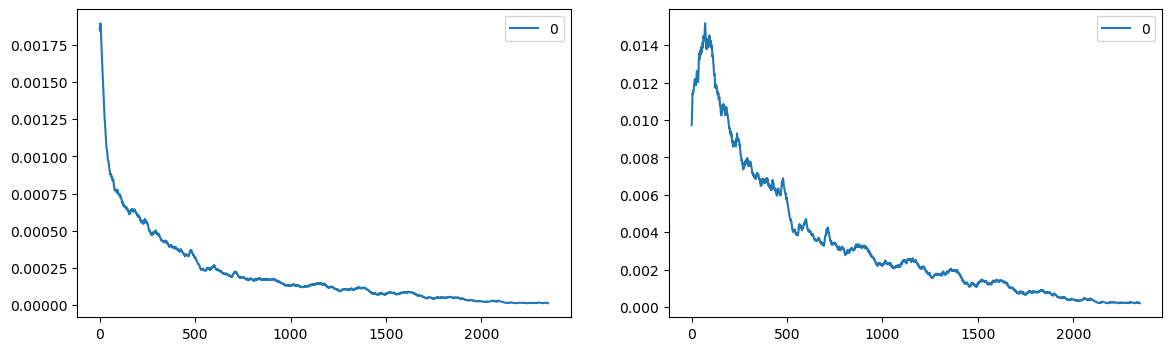

In [ ]:
#|eval: false
axes = subplots(ncols=2,figsize=(14,4))[1]
cb.show(model[0], ax=axes[0])
cb.show(model[2], ax=axes[1])

## Gradients of FFF

In [ ]:
#|hide
#|eval: false
h = 32
d = 3
bs = 256

model_fff = fff.FFF(28*28, h, 10, d, activation=nn.ReLU(), region_leak=0.0)
cbs = [ProbsDistrCB(), GetGradCB([model_fff.node_weights, model_fff.w1s, model_fff.w2s])]
Learner(get_mnist_dls(bs), model_fff, F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(10, lr_max=7e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.256935,0.506443,0.869200,00:26
1,0.175711,0.314463,0.914300,00:27
2,0.156000,0.236128,0.927700,00:39
3,0.117496,0.197913,0.945200,00:31
4,0.099908,0.181206,0.953300,00:26
5,0.069987,0.157113,0.962600,00:30
6,0.039365,0.142038,0.963500,00:35
7,0.022139,0.146598,0.964500,00:31
8,0.012507,0.137407,0.967500,00:26
9,0.008939,0.133419,0.967400,00:33


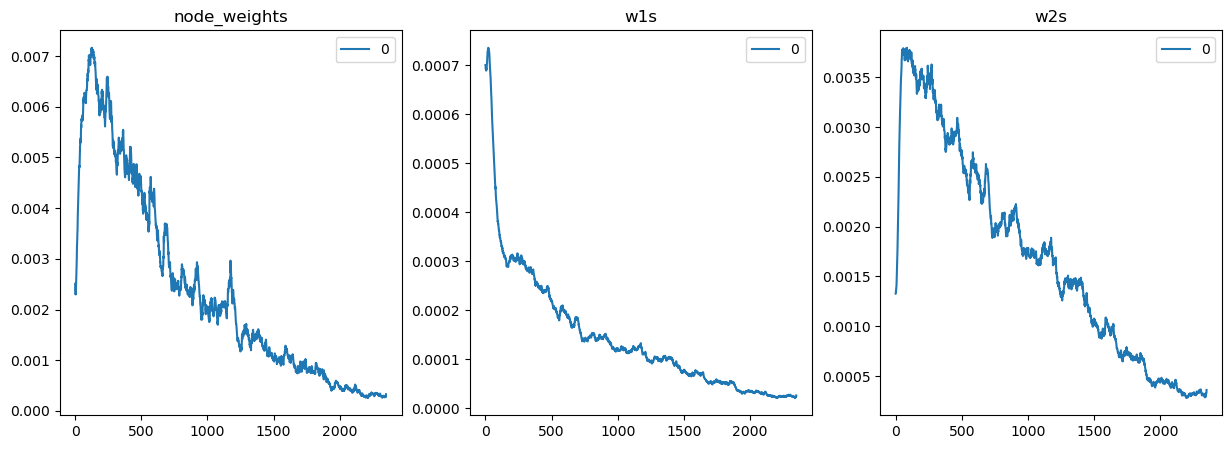

In [ ]:
#|eval: false
axes = subplots(figsize=(15,5), ncols=3)[1]
for i, k in enumerate(['node_weights','w1s','w2s']): axes[i].title.set_text(k)
cbs[1].show(model_fff.node_weights, ax=axes[0])
cbs[1].show(model_fff.w1s, ax=axes[1])
cbs[1].show(model_fff.w2s, ax=axes[2])

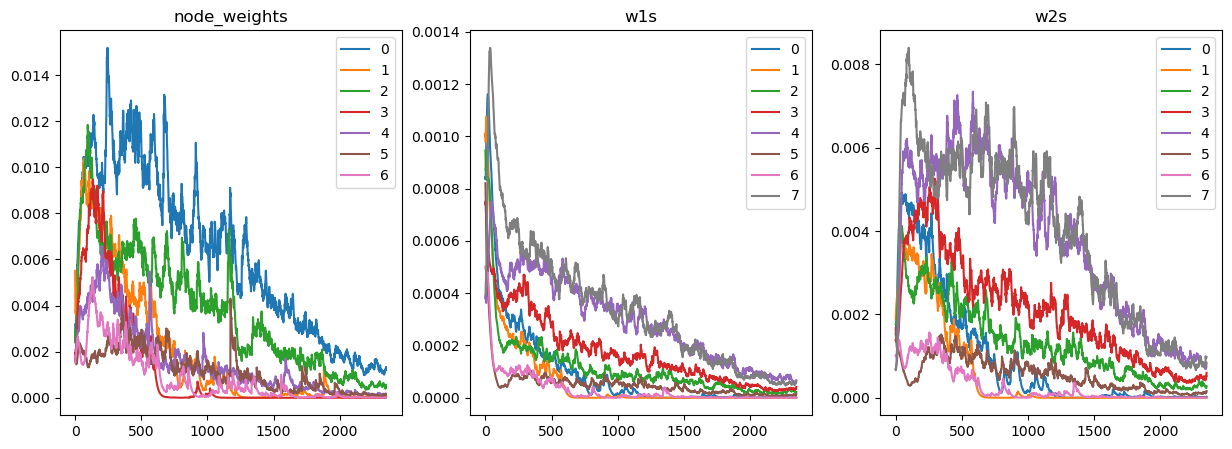

In [ ]:
#|eval: false
axes = subplots(figsize=(15,5), ncols=3)[1]
for i, k in enumerate(['node_weights','w1s','w2s']): axes[i].title.set_text(k)
cbs[1].show(model_fff.node_weights, lambda x: (x.abs().mean(-1)), ax=axes[0])
cbs[1].show(model_fff.w1s, lambda x: (x.abs().mean((-2,-1))), ax=axes[1])
cbs[1].show(model_fff.w2s, lambda x: (x.abs().mean((-2,-1))), ax=axes[2])

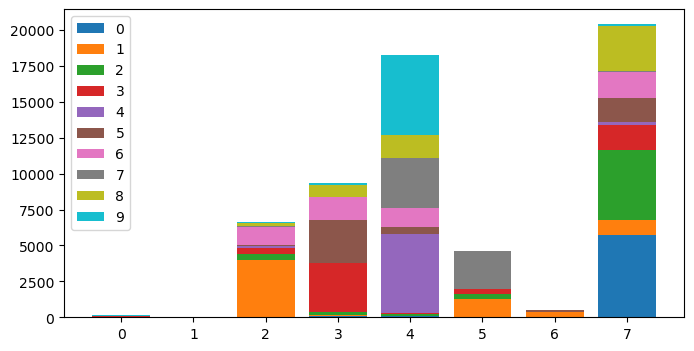

In [ ]:
#|eval: false
ax = subplots(figsize=(8,4))[1][0]
cbs[0].show(-1, ax=ax)

## Test model with region leak

In [ ]:
#|eval: false
h = 32
d = 3
bs = 256

model_fff = fff.FFF(28*28, h, 10, d, activation=nn.ReLU(), region_leak=0.3)
cbs = [ProbsDistrCB(), GetGradCB([model_fff.node_weights, model_fff.w1s, model_fff.w2s])]
Learner(get_mnist_dls(bs), model_fff, F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(10, lr_max=7e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.352248,0.459325,0.859500,00:26
1,0.216082,0.483071,0.854000,00:29
2,0.198191,0.426855,0.872300,00:27
3,0.151039,0.415543,0.875800,00:25
4,0.127004,0.407198,0.889000,00:25
5,0.095422,0.285699,0.923500,00:27
6,0.066441,0.323870,0.911000,00:25
7,0.048498,0.258960,0.927100,00:25
8,0.037923,0.245365,0.933700,00:38
9,0.032860,0.225460,0.938400,00:37


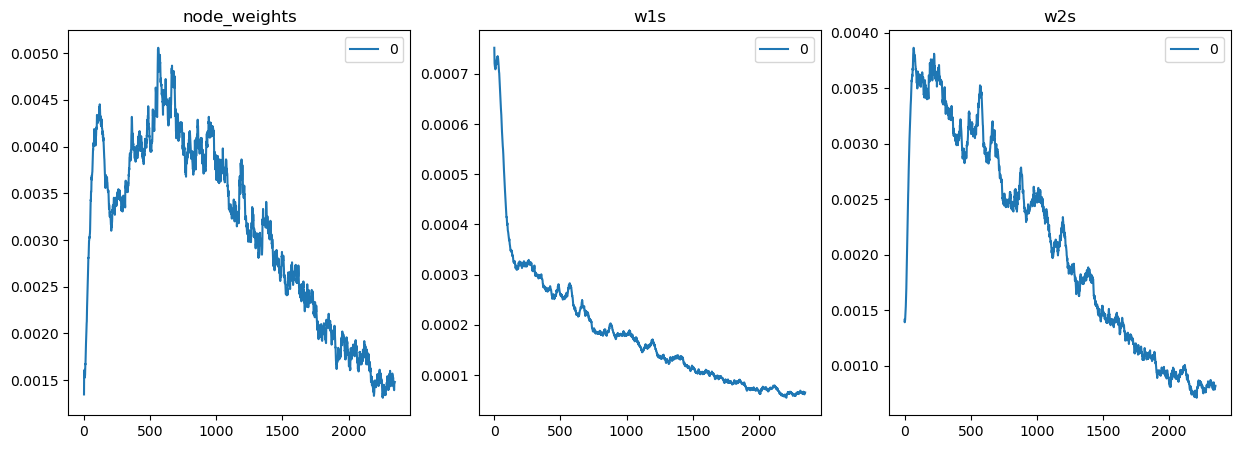

In [ ]:
#|eval: false
axes = subplots(figsize=(15,5), ncols=3)[1]
for i, k in enumerate(['node_weights','w1s','w2s']): axes[i].title.set_text(k)
cbs[1].show(model_fff.node_weights, ax=axes[0])
cbs[1].show(model_fff.w1s, ax=axes[1])
cbs[1].show(model_fff.w2s, ax=axes[2])

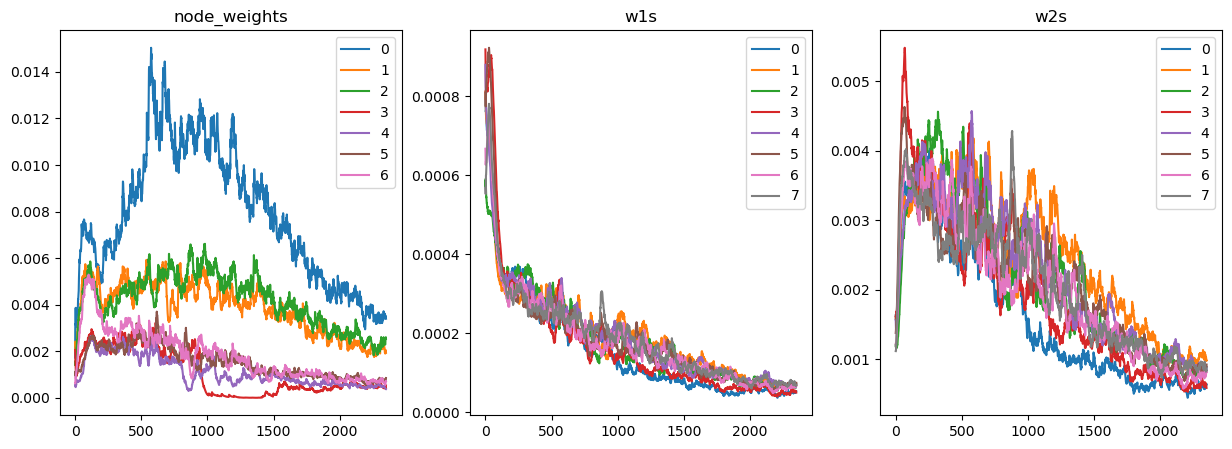

In [ ]:
#|eval: false
axes = subplots(figsize=(15,5), ncols=3)[1]
for i, k in enumerate(['node_weights','w1s','w2s']): axes[i].title.set_text(k)
cbs[1].show(model_fff.node_weights, lambda x: (x.abs().mean(-1)), ax=axes[0])
cbs[1].show(model_fff.w1s, lambda x: (x.abs().mean((-2,-1))), ax=axes[1])
cbs[1].show(model_fff.w2s, lambda x: (x.abs().mean((-2,-1))), ax=axes[2])

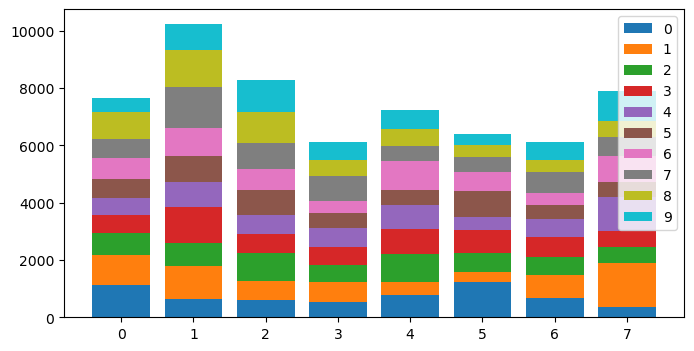

In [ ]:
#|eval: false
ax = subplots(figsize=(8,4))[1][0]
cbs[0].show(-1, ax=ax)

## Epoch dynamics

In [ ]:
#|export
@patch
def show_all_epochs(cb: ProbsDistrCB, n_epoch, ncols=None):
        n_epoch = 10
        ncols = ifnone(ncols, int(n_epoch**0.5))
        fig, axes = subplots(ncols=ncols, nrows=math.ceil(n_epoch/ncols), figsize=(12,5), layout="constrained")
        for i in range(n_epoch):
            ax =  axes[i//ncols][i%ncols] if math.ceil(n_epoch/ncols)>1 else axes[i%ncols]
            ax.set_yticklabels([])
            cb.show(i, ax=ax, show=False)
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels)

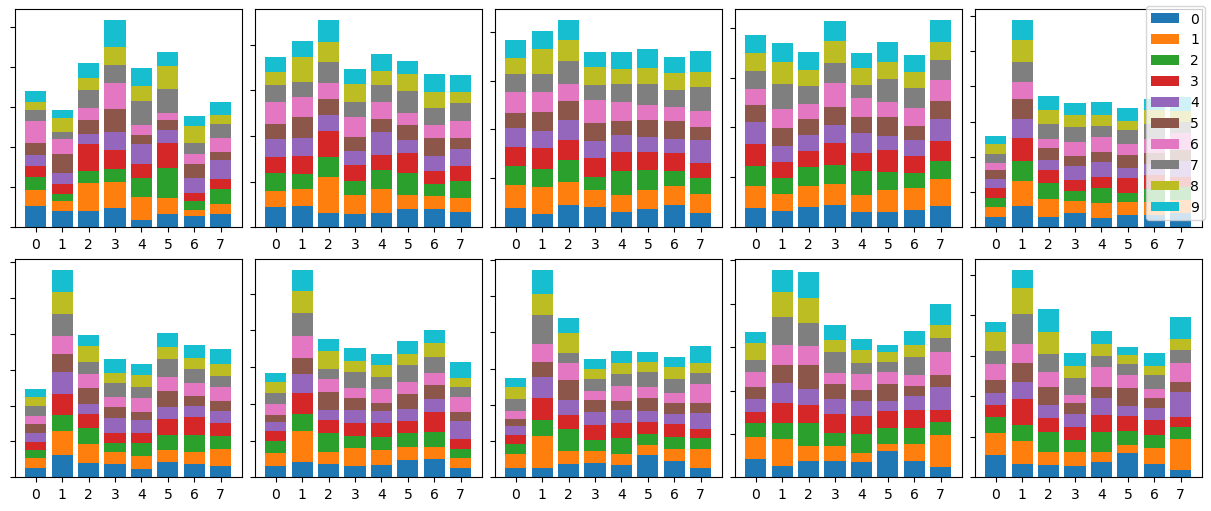

In [ ]:
#|eval: false
cbs[0].show_all_epochs(10, 5)

## Sweep for fff

In [ ]:
sweep_cfg = {
    'name': 'narrow-leafs-sweep',
    'method': 'random',
    'metric':{'name': 'valid_loss','goal':'minimize'},
    'parameters':{
        'bs': {'value': 256},
        'learn':{'parameters':{'lr_max': {'value':7e-3}}},
        'model':{'parameters':{
            'h': {'values': [1,2,4,8]},
            'd': {'values': [1,2,3]},
            'act': {'value': 'relu'},
            'region_leak': {'min':0, 'max':0.5}
            }},
        'epochs': {'value': 15}
    }
}

def run(cfg):
    acts = {'relu': nn.GELU, 'gelu': nn.GELU, 'selu': nn.SELU, 'prelu': nn.PReLU}
    act = acts[cfg.model['act']]()
    model = fff.FFF(28*28, cfg.model['h'], 10, depth =  cfg.model['d'], 
                    region_leak= cfg.model['region_leak'], activation=act)
    cbs = [WandbCallback(log_preds=False), ProbsDistrCB(use_wandb = True, sample_size=100)]
    Learner(get_mnist_dls(cfg.bs), model, F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(cfg.epochs, lr_max=cfg.learn['lr_max'])

In [ ]:
# runs_sweep(sweep_cfg, 'FFF', 5)(run)